# Stock Market Prediction using Time-series and Daily News Analysis
## Time Series Forecasting With ARIMA
### Load Dataset and EDA

In [34]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8,6

pd.set_option('mode.chained_assignment', 'raise') # Raise an exception, warn, or no action if trying to use chained assignment

In [3]:
# Read the combines stock index CSV data file from the data directory
dataset = pd.read_csv('data/comb_data_final.csv',index_col='Date', parse_dates=True)

In [6]:
# Create a separate dataset for our dependant variable with just 'Adj Close'
y = dataset['Adj Close']
# Let's review the summary stats on the dataset: We dont observe anything extreme
print(y.describe().apply("{0:.3f}".format))
print(y.head())

count     1989.000
mean     13463.032
std       3144.007
min       6547.050
25%      10913.380
50%      13025.580
75%      16478.410
max      18312.391
Name: Adj Close, dtype: object
Date
2008-08-08    11734.320312
2008-08-11    11782.349609
2008-08-12    11642.469727
2008-08-13    11532.959961
2008-08-14    11615.929688
Name: Adj Close, dtype: float64


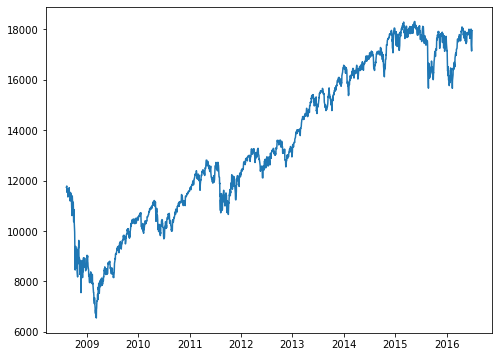

In [30]:
# Lets plot the dataset
plt.plot(y)

# We can see an upward general trend, but no obvious seasonality

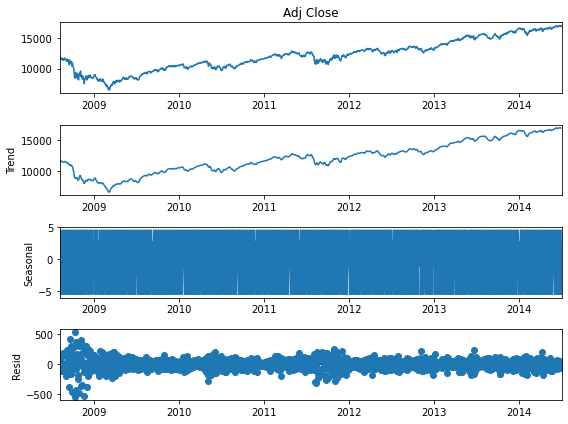

In [32]:
# Check for seasonality and trend by applying seasonal decomposition of data
# Setting the period is an arbitrary choice, but there are 5 trading days in a week, 20 trading days per month, and 253 per year and I tried them all to see if they reveal anything obvious
# There is NO visual seasonality in the dataset which I think is due to the stochastic nature of the stock index data
result_5 = sm.tsa.seasonal_decompose(X_train, model='additive', period=5)
#result_20 = sm.tsa.seasonal_decompose(y, model='additive', period=20)
#result_253 = sm.tsa.seasonal_decompose(y, model='additive', period=253)
result_5.plot();

### Check for Stationarity of dataset
I will use both AdFuller and KPSS tests just to demo both tests. Their null hypotheses are opposite of each other, but they provide the same result.

In [9]:
# Check if price series is stationary using AdFuller test
# Null hypothesis is that the time series is non-stationary
result_adf = adfuller(y) # the dataset has no NaN values, so no need to .dropna()
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# The result tells us the data is indeed non-stationary because we can not reject null hypothesis. (p is higher than 0.05 significance level)

ADF Statistic: -0.3747127512973612
p-value: 0.9142360000847192


In [36]:
# (Optional) Use kpss method to check stationarity
# Null hypothesis is that the time series is stationary
result_kpss = kpss(y)
print(f'ADF Statistic: {result_kpss[0]}')
print(f'p-value: {result_kpss[1]}')

# The result tells us the data is indeed non-stationary because we can reject null hypothesis. (p is less than 0.05 significance level)

ADF Statistic: 7.146903208807145
p-value: 0.01
C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Make the dataset stationary
In our first plot of the dataset, we can see that both the mean and the variance increase as time progresses. To get rid of changing variance, we will take the natural log of all the values in our dataset and to get to a constant mean, we will use differencing. We will do differencing of one since there is no visible seasonality (if there was seasonality, we could have differenced by the seasonal period).

In [37]:
# To make the data stationary, I took the log of data series and differenced it once and dropped any NaN values
y_stationary = np.log(y).diff().dropna()

### Second Check for Stationarity of dataset

In [50]:
# Let's confirm the stationarity of the differenced data with the adfuller test:
result_adfuller2 = adfuller(y_stationary) # 
print(f'ADF Statistic: {result_adfuller2[0]}')
print(f'p-value: {result_adfuller2[1]}')

# Since the test statistic is less than the significance level, we can reject the null hypothesis and assume that the series is stationary now

ADF Statistic: -10.401510921606933
p-value: 1.904073240151235e-18


### Review the ACF and PACF of stationary dataset

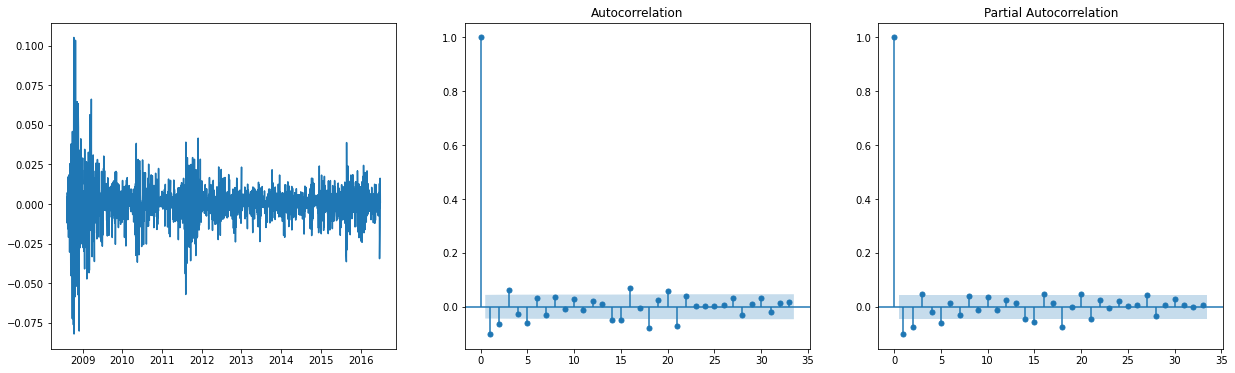

In [45]:
# First differencing: This helps us to determine the value of d which is 1 in this case
# It looks like the returns (differenced data) is randomly distributed around the mean of 0 indicating stationarity
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
ax1.plot(y_stationary)
plot_acf(y_stationary, ax = ax2)
plot_pacf(y_stationary, ax = ax3)
plt.show()

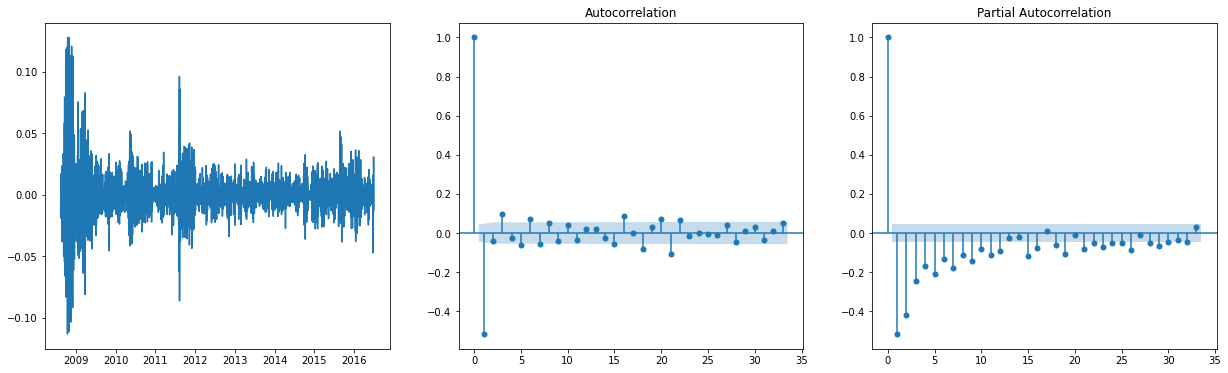

In [53]:
# OPTIONAL step to see if differencing twice is effective
# Twice differencing indicates over-differencing due to the sudden drop in autocorrelation. We will stick with one differencing.
diff1 = y_stationary.diff().dropna()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
ax1.plot(diff1)
plot_acf(diff1, ax = ax2)
plot_pacf(diff1, ax = ax3)
plt.show()

By looking at the PACF of the stationarized series, we can conclude that the p (order of AR model) could be 2 since that is the lag that stands above the significance line.<br>
For the q order term (MA), we review the ACF plot and conclude to be 2 or 3.

However, we will use the ARIMA model to find the optimum values of p and q.

### Train and Test Split

In [54]:
# Set the threshold two years before the last date (at the beginning of 7th year)
threshold = y.index.max() - pd.DateOffset(years=2) 
# Create Train and Test datasets
X_train = dataset[y.index <= threshold]['Adj Close']
X_test = dataset[y.index > threshold]['Adj Close']

In [55]:
X_train.shape

(1484,)

## Arima Model
ARIMA (Auto Regressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA model has 3 parameters:

p - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the PACF (partial autocorrelation function) plot to find the optimal value.

d - the parameter associated with the Integration part of the ARIMA model. This is the order of difference, or the number of times the time series is differenced in order to stationarize the series.

q - the parameter associated with the Moving Average part of the ARIMA model. You can use the ACF (autocorrelation function) plot to find the optimal value.

### Model Fitting

In [57]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


In [92]:
# Use auto_arima method from pmdarima library to find the optimum model with (p,d,q) order
# I will set seasonal=False because I dont think there is any seasonality in the data
import pmdarima as pm
model1 = pm.auto_arima(X_train, # data
                    d=1, # non-seasonal difference order
                    start_p=0, # initial guess for p
                    start_q=0, # initial guess for q
                    max_p=3, # max value of p to test
                    max_q=3, # max value of q to test
                    seasonal=False,
                    stepwise=True,
                    error_action='ignore',
                    trace=True
                    )


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18839.891, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18827.960, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18826.317, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18838.848, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18826.359, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18825.100, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18825.644, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18825.095, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18826.791, Time=0.94 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=18824.274, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18824.440, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=18826.024, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=18824.939, Time=0.23 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.779 seconds


In [93]:
model1.summary() 
# Best model choice is SARIMAX(0,1,3) which means basically it is ARIMA(0,1,3) since there is no seasonal component.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1484
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -9408.137
Date:                Wed, 03 Feb 2021   AIC                          18824.274
Time:                        20:04:06   BIC                          18845.482
Sample:                             0   HQIC                         18832.179
                               - 1484                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0980      0.018     -5.389      0.000      -0.134      -0.062
ma.L2         -0.0468      0.013     -3.513      0.000      -0.073      -0.021
ma.L3          0.0371      0.018      2.084      0.037       0.002       0.072
sigma2      1.898e+04    381.814     49.719      0.000    1.82e+04    1.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1770.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model by adding iterative Test data to Training data

In [80]:
history = [x for x in X_train]
model_predictions = []
N_test_observations = len(X_test)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(0,1,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = X_test[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(X_test, model_predictions)
print('Root Mean Squared Error is {}'.format(np.sqrt(MSE_error)))

Root Mean Squared Error is 157.18979735459604


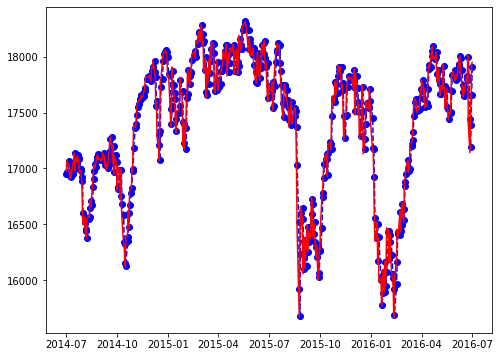

In [79]:
# Plot the predictions against the test data
test_set_range = X_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, X_test, color='red', label='Actual Price')

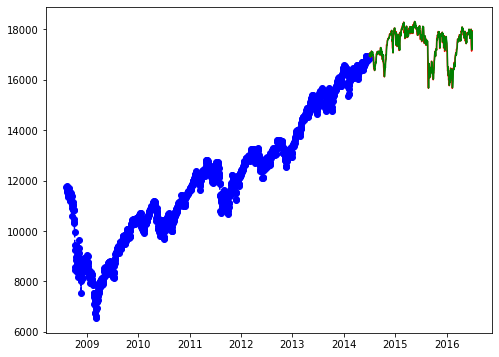

In [81]:
# Plot the full train and test data sets and predictions
test_set_range = X_test.index
y_set_range = X_train.index
plt.plot(X_train, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, X_test, color='red', label='Actual Price')
plt.plot(test_set_range, model_predictions, color='green', label='Predicted Price')

The ARIMA model provided an very good result once we used the test data by iteratively adding it to the training data.

### Optional Approach

In [91]:
# Ignore seasonality to build auto_arima
model1 = pm.auto_arima(X_train, d=1,start_p=0, start_q=0,max_p=3, max_q=3, 
seasonal=False, 
trace=True,error_action='ignore',suppress_warnings=True)

# ARIMA(0,1,3) model seems to be the best without differencing

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18839.891, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18827.960, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18826.317, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18838.848, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18826.359, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18825.100, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18825.644, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18825.095, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18826.791, Time=0.82 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=18824.274, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18824.440, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=18826.024, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=18824.939, Time=0.22 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.463 seconds


In [111]:
# Build ARIMA with recommended order
model_arima = ARIMA(X_train, order=(0,1,3))
model_fit = model_arima.fit()
forecast = model_fit.predict(505)# predict vs_ forecast??
fc, se, conf = model_fit.forecast(505, alpha=0.05)  # 95% conf
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1483
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -9407.523
Method:                       css-mle   S.D. of innovations            137.639
Date:                Wed, 03 Feb 2021   AIC                          18825.046
Time:                        20:10:57   BIC                          18851.555
Sample:                             1   HQIC                         18834.927
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.5096      3.185      1.102      0.271      -2.734       9.753
ma.L1.D.Adj Close    -0.0991      0.026     -3.827      0.000      -0.150      -0.048
ma.L2.D.Adj Close    -0.

In [97]:
# Make as pandas series
fc_series = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf[:, 0], index=X_test.index)
upper_series = pd.Series(conf[:, 1], index=X_test.index)

In [98]:
rmse=np.sqrt(np.mean(np.power((np.array(X_test)-np.array(fc_series)),2)))
rmse

894.3433476690957

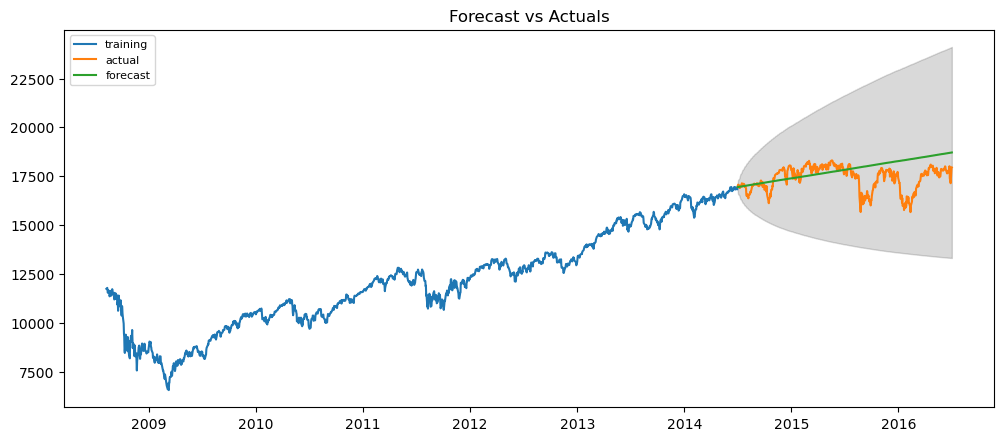

In [99]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train, label='training')
plt.plot(X_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()